# Build community model

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
sys.path.append('/home/UCSD/cobra_utils')
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *

import copy
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))
plt.rcParams['svg.fonttype'] = 'none'

/home/jt/work/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/work/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/work/cobrapy-0.5.11/cobra/__init__.py
/home/jt/work/cobrame/cobrame/__init__.py
/home/jt/work/bacillusme-master/bacillusme/__init__.py


In [2]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-16


<Solution 0.12 at 0x7fcd26706590>

In [3]:
# with open(ecoli_files+'/me_models/solution.pickle', 'rb') as solution:
#     me = pickle.load(solution)
with open(ecoli_files+'/me_models/solution_spore.pickle', 'rb') as solution:
    spore = pickle.load(solution)

In [4]:
with open(ecoli_files+'/me_models/iJT964-ME.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [5]:
flux_based_reactions(me,'BSU10520-MONOMER')

,lb,ub,rxn_flux,met_flux,reaction
MANt2_FWD_BSU10520-MONOMER,0,999999,0,-0,8.25783209324814e-5*mu BSU10520-MONOMER + h_e ...
GLCt2_FWD_BSU10520-MONOMER,0,999999,0,-0,4.27350427350427e-6*mu BSU10520-MONOMER + glc_...
MAN6Pt6_REV_BSU10520-MONOMER,0,999999,0,-0,4.27350427350427e-6*mu BSU10520-MONOMER + h_c ...
formation_BSU10520-MONOMER,0,1000,0,0,protein_BSU10520_Inner_Membrane --> BSU10520-M...
MAN6Pt6_FWD_BSU10520-MONOMER,0,999999,0,-0,4.27350427350427e-6*mu BSU10520-MONOMER + h_e ...


## Create spore model

### Change IDs (compartment _s)

In [6]:
# Metabolites
new_compartment = 's'
fix = []
for met in tqdm(spore.metabolites):
    if re.search('_[c,e]$',met.id):
        met.id = re.sub('c$',new_compartment,met.id)
    else:
        met.id = met.id+'_'+new_compartment

100%|██████████| 3445/3445 [00:00<00:00, 749954.70it/s]


In [7]:
# Reactions
new_compartment = 's'
fix = []
for r in tqdm(spore.reactions):
        r.id = r.id+'_'+new_compartment

100%|██████████| 5314/5314 [00:00<00:00, 1665311.67it/s]


In [8]:
spore.repair()

In [9]:
# Create new growth key for spore
new_growth_key = 'sigma'
for r in tqdm(spore.reactions):
    lb = r.lower_bound
    ub = r.upper_bound
    new_stoichiometry = {m:s for m,s in r.metabolites.items()}
    if hasattr(lb, 'subs'):
        growth_key = list(lb.free_symbols)[0]
        r.lower_bound = lb.subs(growth_key,new_growth_key)
    if hasattr(ub, 'subs'):
        growth_key = list(ub.free_symbols)[0]
        r.upper_bound = ub.subs(growth_key,new_growth_key)
    for m,s in new_stoichiometry.items():
        if hasattr(s, 'subs'):
            growth_key = list(s.free_symbols)[0]
            new_stoichiometry[m] = s.subs(growth_key,new_growth_key)
    r.add_metabolites(new_stoichiometry,combine=False)

100%|██████████| 5314/5314 [00:06<00:00, 871.53it/s] 


In [10]:
# Eliminate exchange reactions:
reactions = [r for r in spore.reactions]
for r in tqdm(reactions):
    if re.search('^EX_',r.id):
        r.remove_from_model()

100%|██████████| 5314/5314 [00:00<00:00, 78026.05it/s]


### Create spore biomass reactions

In [11]:
bio_rxn = spore.reactions.BIOMASS_BS_10_FWD_CPLX_dummy_s

In [12]:
bio_comp = pd.read_csv('spore_composition.csv',index_col=0)

In [13]:
# Identify lipid metabolites in biomass equation
lipid_demand = {}
for m in bio_comp.index:
    if '_BS_c' in m:
        new_id = re.sub('c$','s',m)
        value = bio_comp.loc[m]['coeff']
        lipid_demand[new_id] = abs(value)
                
for met, requirement in lipid_demand.items():
    component_mass = spore.metabolites.get_by_id(met).formula_weight / 1000.
    rxn = cobrame.SummaryVariable('Demand_' + met)
    spore.add_reactions([rxn])
    rxn.add_metabolites({met: -1 * requirement,
                         'lipid_biomass_s': component_mass * requirement})
    rxn.lower_bound = spore.reactions.biomass_dilution_s.lower_bound
    rxn.upper_bound = 1000.
#     print(rxn.reaction)

### Merge

In [14]:
with open(ecoli_files+'/me_models/solution_mother.pickle', 'rb') as solution:
    sporeme = pickle.load(solution)

In [15]:
# Mother is not growing. Reactions should then be associated to sigma
new_growth_key = 'sigma'
for r in tqdm(sporeme.reactions):
    lb = r.lower_bound
    ub = r.upper_bound
    new_stoichiometry = {m:s for m,s in r.metabolites.items()}
    if hasattr(lb, 'subs'):
        growth_key = list(lb.free_symbols)[0]
        r.lower_bound = float(lb.subs(growth_key,0.))
    if hasattr(ub, 'subs'):
        growth_key = list(ub.free_symbols)[0]
        r.upper_bound = float(ub.subs(growth_key,1000.))
    for m,s in new_stoichiometry.items():
        if hasattr(s, 'subs'):
            growth_key = list(s.free_symbols)[0]
            new_stoichiometry[m] = s.subs(growth_key,new_growth_key)
            a = 1
    r.add_metabolites(new_stoichiometry,combine=False)

100%|██████████| 6307/6307 [00:08<00:00, 755.80it/s] 


In [16]:
# sporeme.add_reactions(spore.reactions) # This approach no longer worked after python version change.

In [17]:
# Add spore reactions
for r in tqdm(spore.reactions):
    new = r.__class__(r.id) # Create and identical reaction
    new.bounds = r.bounds
    sporeme.add_reaction(new)
    for k,v in r.metabolites.items():
        if not hasattr(sporeme.metabolites,k.id):
            args = k.__init__.__code__.co_varnames[1:] # Eliminate "self"
            if len(args) == 1: # No additional inputs to __init__
                met = k.__class__(k.id)
            else:
                vals = [getattr(k, dir(k)[[i.lower() for i in dir(k)].index(a)]) for a in args]
                met = k.__class__(*vals)
            sporeme.add_metabolites(met)
            met.name = k.name
            met.formula = k.formula
            met.charge = k.charge
            met.compartment = 's'
            
        new.add_metabolites({k.id:v})

100%|██████████| 5083/5083 [00:03<00:00, 1555.44it/s]


In [18]:
# Connect C with S
## Change spore transport from e-s to c-s
for m in tqdm(sporeme.metabolites):
    if not isinstance(m,cobrame.Metabolite) or not re.search('_s$',m.id):
        continue
    in_transport = get_transport_reactions(sporeme,m.id,comps=['e','s'])
    out_transport = get_transport_reactions(sporeme,m.id,comps=['s','e'])
    transport_reactions = in_transport + out_transport
    for r in transport_reactions:
        old_met = sporeme.metabolites.get_by_id(re.sub('_s$','_e',m.id))
        new_met = sporeme.metabolites.get_by_id(re.sub('_s$','_c',m.id))
        coeff = r.metabolites[old_met]
        r.add_metabolites({old_met:-coeff,new_met:coeff})

100%|██████████| 7443/7443 [00:00<00:00, 18974.64it/s]


In [19]:
sporeme.objective = 'biomass_dilution_s'
sporeme.reactions.get_by_id('BIOMASS_BS_10_FWD_CPLX_dummy_s').upper_bound = 0

### Correct spoIIIAA-H - spoIIQ formation

In [20]:
sporeme.reactions.get_by_id('formation_PORE-CPLX').remove_from_model()

In [21]:
old_formation = sporeme.reactions.get_by_id('formation_PORE-CPLX_s')

In [22]:
new_stoich = {}
for k,v in old_formation.metabolites.items():
    if v > 0 or 'BSU36550' in k.id: # spoIIQ is from the spore
        new_stoich[k] = v
        continue
    newk = k.id.split('_s')[0]
    new_stoich[sporeme.metabolites.get_by_id(newk)] = v

In [23]:
new_formation = cobrame.core.reaction.ComplexFormation('formation_combined_PORE-CPLX_s')
sporeme.add_reactions([new_formation])
new_formation.add_metabolites(new_stoich)
print(new_formation.reaction)

12.0 protein_BSU24360_Inner_Membrane + 30.0 protein_BSU24370_Inner_Membrane + protein_BSU24380_Inner_Membrane + protein_BSU24390_Inner_Membrane + protein_BSU24400_Inner_Membrane + protein_BSU24410_Inner_Membrane + protein_BSU24420_Inner_Membrane + 6.0 protein_BSU24430_Inner_Membrane + 12.0 protein_BSU36550_Inner_Membrane_s --> PORE-CPLX_s


In [24]:
old_formation.remove_from_model()

In [25]:
sporeme.reactions.query('formation_.*PORE')

[<ComplexFormation formation_combined_PORE-CPLX_s at 0x7fcc83f6a6d0>]

### Peptidoglycan

##### Spore peptidoglycan precursors are synthesized in the mother cell19 and are flipped across the outer forespore membrane into the intermembrane space by an as yet incompletely understood mechanism20. 
https://www.nature.com/articles/nrmicro2921

Moreover, sigK is responsible for this biosynthesis activation, and it is an MC sigma factor. This makes sigK not essential in the FS anymore

In [26]:
r = sporeme.reactions.get_by_id('biomass_constituent_demand_s')
m = sporeme.metabolites.get_by_id('peptido_BS_s')
newm = sporeme.metabolites.get_by_id('peptido_BS_c')
r.add_metabolites({newm:r.metabolites[m],
                   m:-r.metabolites[m]})
r.metabolites

{<Metabolite 10fthf_s at 0x7fcc8a340d90>: -0.000367,
 <Metabolite psetha_BS_s at 0x7fcc88affa90>: -0.00056,
 <Constraint constituent_biomass_s at 0x7fcc81734e50>: 0.13926027055704,
 <Metabolite peptido_BS_c at 0x7fcc82274510>: -0.101817}

### Close ATP synthase as it seems it is not present in the spore according to Eammons thesis


In [27]:
for r in sporeme.reactions.query('ATPS.*_s'):
    print(r.id,r.reaction)
    r.bounds = (0,0)
# sporeme.reactions.get_by_id('ATPS4r_FWD_CPLX000-10_s').bounds = (0,0)
# No glucose uptake from e
# sporeme.reactions.get_by_id('GLCpts_FWD_BSU13890-MONOMER_s').bounds = (0,0)
for r in sporeme.reactions.query('GLCpts.*_s'):
    print(r.id,r.reaction)
    r.bounds = (0,0)

ATPS4r_REV_PORE-CPLX_s atp_s + h2o_s + 3.0 h_s --> -4.27350427350427e-6*sigma PORE-CPLX_s + adp_s + 4.0 h_c + pi_s
ATPS4r_FWD_PORE-CPLX_s adp_s + 4.0 h_c + pi_s --> -4.27350427350427e-6*sigma PORE-CPLX_s + atp_s + h2o_s + 3.0 h_s
GLCpts_FWD_PORE-CPLX_s glc__D_e + pep_s --> -4.27350427350427e-6*sigma PORE-CPLX_s + g6p_s + pyr_s


In [28]:
solve_me_model(sporeme, max_mu = 0.1, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 50.840711 seconds
Finished substituting S,lb,ub in 1.764709 seconds
Finished makeME_LP in 0.245785 seconds
Getting MINOS parameters from ME_NLP...
 Allocating name1, name2
 Allocating pi, rc, xn
 Allocated pi, rc, xn
 No Jacobian matrix since no nonlinear obj or constraints
C0028000000000000000000000000000
 C028000000000000
C0028000000000000000000000000000
C083D6329F1C35CA5000000000000000
 C83D6329F1C35CA5
C083D6329F1C35CA5000000000000000
4083D6329F1C35CA5000000000000000
 483D6329F1C35CA5
4083D6329F1C35CA5000000000000000
 Calling miopt to set option: Maximize
 Calling miopt to set option: Solution No
 Calling miopti to set option New basis file to           11
 Calling miopti to set option Save frequency to       500000
 Calling miopti to set option Print level to            0
 Calling miopti to set option Print frequency to       100000
 Calling miopti to set option Scale option to            2
 Calling mi

In [29]:
sporeme.name = 'Spore model with spoIIIA-H - spoIIQ pore channel'
with open("./sporeme_solution_v4_proteomics_spoAQ_naive.pickle", "wb") as outfile:
    pickle.dump(sporeme, outfile)

### Close specific reactions in the spore
Sporulation allows bacteria to survive adverse conditions and is essential to the lifecycle of some obligate anaerobes. In Bacillus subtilis, the sporulation-specific sigma factors, σF, σE, σG, and σK, activate compartment-specific transcriptional programs that drive sporulation through its morphological stages

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4380625/

In [30]:
# From proteomics. ilvE = ybgE
gene_dictionary = pd.read_csv('../../building_data/gene_name_dictionary.csv',index_col=1)

deplete_genes = set(['pckA','purL','ilvB','ilvE','citZ','acsA','etfA','acoC','sigF','yxbC','lutC',
                  'argJ','hpf'])
deplete_genes -= set(['sigF']) # sigF and sigG are FS sigma factors
deplete_genes = deplete_genes | set(['sigE', 'sigKc', 'sigKn']) # sigE and sigK are MC sigma factors

deplete_genes = set(gene_dictionary.loc[deplete_genes]['locus_id'])

In [31]:
eliminate_genes = (deplete_genes)
len(eliminate_genes)

15

In [32]:
# # From Eammon's paper.
# # https://www.science.org/doi/10.1126/sciadv.abd6385
# eliminate_genes = ['citB','citZ','icd','sucD','fumC','mdh']
# gene_dictionary.loc[eliminate_genes]['locus_id']

In [33]:
essentiality_df = pd.read_csv('../essentiality/essentiality_results.csv',index_col=0)
eliminate_ids = set(eliminate_genes) & set(essentiality_df.index)
essentiality_df.loc[eliminate_ids]

,response_me,essentiality_me,response_m,essentiality_m,true_essentiality
BSU02390,0.000000,0,0.000000e+00,0,0
BSU15320,-1.000000,e,NaN,NaN,0
BSU11200,-1.000000,e,-1.000000e+00,e,0
BSU28310,-0.000009,0,0.000000e+00,0,0
BSU30560,0.000000,0,-1.828217e-10,0,0
BSU06480,0.000000,0,-1.000000e+00,e,0
BSU25760,-1.000000,e,NaN,NaN,0
BSU26390,-1.000000,e,NaN,NaN,0
BSU29680,0.000000,0,-1.302820e-10,0,0
BSU29140,-0.000028,0,0.000000e+00,0,0


In [34]:
for gene in eliminate_ids:
    r = 'translation_' + gene +'_s'
    if r not in sporeme.reactions:
        print(r+" not in model")
        continue
    print(r)
    rxn = sporeme.reactions.get_by_id(r)
    rxn.bounds = (0,0)

translation_BSU02390_s
translation_BSU15320_s
translation_BSU11200_s
translation_BSU28310_s
translation_BSU30560_s
translation_BSU06480_s
translation_BSU25760_s
translation_BSU26390_s
translation_BSU29680_s
translation_BSU29140_s


### Solve

In [35]:
solve_me_model(sporeme, max_mu = 0.1, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 50.076952 seconds
Finished substituting S,lb,ub in 1.761200 seconds
Finished makeME_LP in 0.248471 seconds
Getting MINOS parameters from ME_NLP...
 Allocating name1, name2
 Allocating pi, rc, xn
 Allocated pi, rc, xn
 No Jacobian matrix since no nonlinear obj or constraints
C0028000000000000000000000000000
 C028000000000000
C0028000000000000000000000000000
C083D6329F1C35CA5000000000000000
 C83D6329F1C35CA5
C083D6329F1C35CA5000000000000000
4083D6329F1C35CA5000000000000000
 483D6329F1C35CA5
4083D6329F1C35CA5000000000000000
 Calling miopt to set option: Maximize
 Calling miopt to set option: Solution No
 Calling miopti to set option New basis file to           11
 Calling miopti to set option Save frequency to       500000
 Calling miopti to set option Print level to            0
 Calling miopti to set option Print frequency to       100000
 Calling miopti to set option Scale option to            2
 Calling mi

In [36]:
sporeme.name = 'Spore model with Eammons proteomics constraints and spoIIIA-H - spoIIQ pore channel'
with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "wb") as outfile:
    pickle.dump(sporeme, outfile)

In [37]:
import pickle

In [38]:
with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [39]:
sporeme.solution.x_dict['EX_glc__D_e']

-1.699988990778921

In [40]:
sporeme.solution.x_dict['biomass_dilution_s']

0.041169738769531256

In [41]:
sporeme.reactions.query("CYTK")

[<MetabolicReaction CYTK1_REV_BSU22890-MONOMER_mod_mg2 at 0x7fcc75b2fc90>,
 <MetabolicReaction CYTK1_FWD_BSU22890-MONOMER_mod_mg2 at 0x7fcc75b2ff10>,
 <MetabolicReaction CYTK2_REV_BSU22890-MONOMER_mod_mg2 at 0x7fcc75b2ff90>,
 <MetabolicReaction CYTK2_FWD_BSU22890-MONOMER_mod_mg2 at 0x7fcc75b372d0>,
 <MetabolicReaction CYTK1_REV_BSU22890-MONOMER_mod_mg2_s at 0x7fcc750f89d0>,
 <MetabolicReaction CYTK1_FWD_BSU22890-MONOMER_mod_mg2_s at 0x7fcc750f8a50>,
 <MetabolicReaction CYTK2_REV_BSU22890-MONOMER_mod_mg2_s at 0x7fcc750f8ad0>,
 <MetabolicReaction CYTK2_FWD_BSU22890-MONOMER_mod_mg2_s at 0x7fcc750f8d10>]

## Properties

In [42]:
len(sporeme.metabolites.query('.*_s$')),\
len(sporeme.reactions.query('.*_s$')),\
len(sporeme.metabolites.query('protein_BSU\d*_s$'))

(3204, 5083, 732)

In [43]:
len(set(sporeme.metabolites) - set(sporeme.metabolites.query('.*_s$'))),\
len(set(sporeme.reactions) - set(sporeme.reactions.query('.*_s$'))),\
len(sporeme.metabolites.query('protein_BSU\d*[^s]$'))

(4239, 6306, 973)

In [44]:
len(sporeme.metabolites),\
len(sporeme.reactions),\
len(sporeme.metabolites.query('protein_BSU\d*_*s*$'))

(7443, 11389, 1705)

In [45]:
def get_breakdown(me,field):
    count = {}
    for instance in getattr(me,field):
        instance_type = instance.__class__.__name__
        if instance_type not in count.keys():
            count[instance_type] = 0
        count[instance_type] += 1
    return pd.DataFrame.from_dict({'count':count})

<AxesSubplot:>

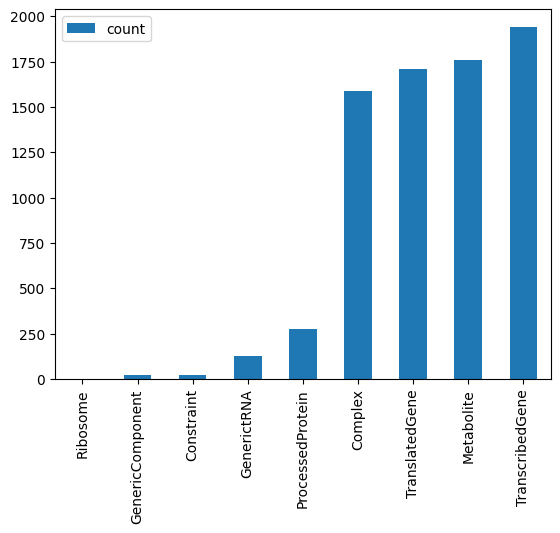

In [46]:
get_breakdown(sporeme,'metabolites').sort_values('count').plot.bar()

<AxesSubplot:>

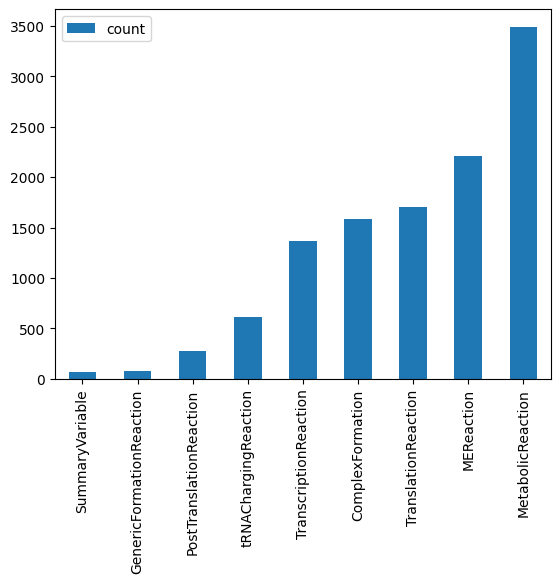

In [47]:
get_breakdown(sporeme,'reactions').sort_values('count').plot.bar()

In [48]:
d = {}
for r in sporeme.reactions:
    try:
        rxn = r.reaction
    except:
        rxn = ''
    d[r.id] = {
        'lower_bound' : r.lower_bound,
        'upper_bound' : r.upper_bound,
        'reaction' : rxn,
        'subsystem' : r.subsystem,
        'flux' : sporeme.solution.x_dict[r.id]
    }

In [49]:
pd.DataFrame.from_dict(d).T.to_csv('Supplementary Files/Supplementary File 1.csv')

## ATP mechanisms

In [50]:
pd.set_option('display.max_colwidth', None)

In [51]:
df = flux_based_reactions(sporeme,'atp_s',only_types=['MetabolicReaction'],growth_symbol = 'sigma')

In [52]:
flux_based_reactions(sporeme,"BSU22890-MONOMER_s",growth_symbol='sigma')

No reactions found for BSU22890-MONOMER_s


In [53]:
prod_df = df[df['met_flux']>0]['met_flux']
prod_df.div(prod_df.sum())

PYK_FWD_BSU29180-MONOMER_mod_mn2_mod_k_s           0.49173
PGK_REV_BSU33930-MONOMER_s                        0.477894
SUCOAS_REV_CPLX8J2-7_s                           0.0121611
PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi_s      0.0111656
ADK1_REV_BSU01370-MONOMER_mod_mg2_s             0.00704916
FACOAL161_ISO_REV_BSU10270-MONOMER_s           5.84016e-20
Name: met_flux, dtype: object

In [54]:
sporeme.reactions.get_by_id('PRPPS_REV_BSU00510-MONOMER_mod_mn2_mod_pi_s').reaction

'amp_s + h_s + prpp_s --> -1.38413361031386e-5*sigma BSU00510-MONOMER_mod_mn2_mod_pi_s + atp_s + r5p_s'

In [55]:
sporeme.reactions.get_by_id('ADK1_REV_BSU01370-MONOMER_mod_mg2_s').reaction

'2.0 adp_s --> -4.27350427350427e-6*sigma BSU01370-MONOMER_mod_mg2_s + amp_s + atp_s'

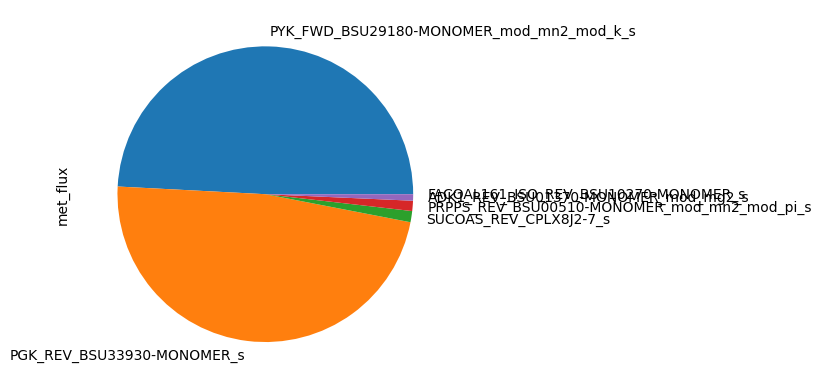

In [56]:
prod_df.plot.pie()
plt.savefig('figures/ATP_synthesis_spoAQ.svg',format='SVG')

## NADH mechanisms

In [57]:
df = flux_based_reactions(sporeme,'nadh_s',only_types=['MetabolicReaction'],growth_symbol = 'sigma')

In [58]:
prod_df = df[df['met_flux']>0]['met_flux']
prod_df.div(prod_df.sum())

GAPD_FWD_BSU33940-MONOMER_s       0.962391
AKGDH_FWD_CPLX000-5_s            0.0244903
PDH_FWD_CPLX000-61_s             0.0111769
OIVD3_FWD_CPLX000-60_s         0.000987907
OIVD1r_FWD_CPLX000-58_s         0.00052301
MDH_FWD_BSU29120-MONOMER_s     0.000314802
OIVD2_FWD_CPLX000-59_s         0.000116224
Name: met_flux, dtype: object

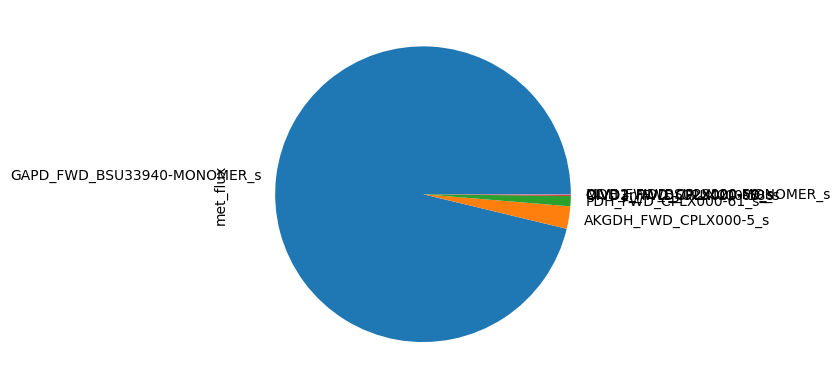

In [59]:
prod_df.plot.pie()
plt.savefig('figures/NADH_synthesis_spoAQ.svg',format='SVG')

In [60]:
locus_to_name['BSU19370']

NameError: name 'locus_to_name' is not defined

In [ ]:
flux_based_reactions(sporeme,'CPLX000-61_s',growth_symbol = 'sigma')

In [ ]:
flux_based_reactions(sporeme,'CPLX000-5_s',growth_symbol = 'sigma')

In [ ]:
flux_based_reactions(sporeme,'akg_s',growth_symbol = 'sigma')

In [ ]:
sporeme.reactions.get_by_id('PDH_FWD_CPLX000-61').subsystem

In [ ]:
sporeme.reactions.get_by_id('AKGDH_FWD_CPLX000-5').subsystem

### PORE

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
flux_based_reactions(sporeme,'PORE-CPLX_s',growth_symbol = 'sigma')

In [ ]:
for i in sporeme.reactions.get_by_id('formation_combined_PORE-CPLX_s').reaction.split('+'):
    print(i)

In [ ]:
locus_to_name = pd.read_csv('../gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('../gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()

In [ ]:
l = ['sigKc','sigKn','sigE','sigF','sigG']
d = {}
for j in l:
    i = name_to_locus[j]
    rfs = 'translation_{}_s'.format(i)
    if not sporeme.reactions.has_id(rfs):continue
    rmc = 'translation_{}'.format(i)
    
    d[j] = {
        'MC' : sporeme.solution.x_dict[rmc],
        'FS' : sporeme.solution.x_dict[rfs]
    }
(pd.DataFrame.from_dict(d)*1e9).T

In [ ]:
l = [i for i in name_to_locus if 'spoIIIA' in i] + ['spoIIQ']
d = {}
for j in l:
    i = name_to_locus[j]
    rfs = 'translation_{}_s'.format(i)
    if not sporeme.reactions.has_id(rfs):continue
    rmc = 'translation_{}'.format(i)
    
    d[j] = {
        'MC' : sporeme.solution.x_dict[rmc],
        'FS' : sporeme.solution.x_dict[rfs]
    }
(pd.DataFrame.from_dict(d)*1e9).sort_index(True).T

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
flux_based_reactions(sporeme,"BSU29140-MONOMER",growth_symbol='sigma')

In [ ]:
flux_based_reactions(sporeme,'biomass',growth_symbol = 'sigma')

In [ ]:
flux_based_reactions(sporeme,'glc__D_e',growth_symbol = 'sigma')

In [ ]:
flux_based_reactions(sporeme,'protein_biomass',growth_symbol = 'sigma')

In [ ]:
flux_based_reactions(sporeme,'protein_BSU14900',growth_symbol = 'sigma')

In [ ]:
sporeme.metabolites.protein_BSU24370.reactions

In [ ]:
flux_based_reactions(sporeme,'protein_biomass_s',growth_symbol = 'sigma')

In [ ]:
sporeme.reactions.biomass_dilution_s.bounds

In [ ]:
sporeme.reactions.biomass_dilution.bounds

In [ ]:
flux_based_reactions(sporeme,'glc__D_e',only_types=['MetabolicReaction'],growth_symbol = 'sigma')